# Оценка качества поиска

In [182]:
!pip install faiss-cpu annoy

In [183]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
import faiss
from annoy import AnnoyIndex

from typing import Callable, List, Literal, defaultdict
import cv2
from PIL import Image
import matplotlib.pyplot as plt

In [184]:
metadata = pd.read_csv('metadata.csv')
metadata.head(5)

,Unnamed: 0,id,product_title,product_description,filename,format,mode,resolution,filesize,retrieved,file_exists,merged_text
0,0,209650955,Триммер садовый электрический для травы,Модель беспроводной; аккумуляторный; ручной Ти...,res/img/209650955.png,PNG,RGBA,"(246, 328)",171.35,2024-03-21 11:10:04.299254016,True,триммер садовый электрический для травы модель...
1,1,77278318,Триммер аккумуляторный садовый дачный кусторез,Модель разборная модель Питание Аккумулятор (в...,res/img/77278318.png,PNG,RGBA,"(246, 328)",160.00,2024-03-21 11:13:44.241293056,True,триммер аккумуляторный садовый дачный кусторез...
2,2,18565737,Триммер аккумуляторный ZITREK GreenCut 20 (20В...,Модель GreenCut 20 Гарантийный срок 1 год Тип ...,res/img/18565737.png,PNG,RGBA,"(246, 328)",17.67,2024-03-21 11:13:58.767094016,True,триммер аккумуляторный zitrek greencut 20 (20в...
3,3,113066515,Триммер аккумуляторный садовый дачный кусторез,Модель разборная модель Питание Аккумулятор (в...,res/img/113066515.png,PNG,RGBA,"(246, 328)",128.90,2024-03-21 11:14:13.620366080,True,триммер аккумуляторный садовый дачный кусторез...
4,4,151530782,Триммер-газонокосилка аккумуляторный ZITREK Gr...,Модель GreenCut 20 Pro Гарантийный срок 1 год ...,res/img/151530782.png,PNG,RGBA,"(246, 328)",128.13,2024-03-21 11:14:27.381707008,True,триммергазонокосилка аккумуляторный zitrek gre...


# Labeling the data

Имитируем работу экспертов простой функцией, которая будет искать запрос в описании текста (в явно виде) и помечать результат как relevent (1) или irrelevant (0) текущему поисковому запросу. 

Для этого сначала составим список запросов, на основе которых будем оценивать качество поисковых систем. 

Предположим, что поисковый запрос "бензокоса" будет соответсвовать наименованию товара "триммер бензиновый", 
"железная машинка" наименованию "машинка металлическая", а запросу "леска для косы" - "леска для триммера". Это нужно для работы нашего "искусственного эксперта", чтобы он помечал дословные вхождения как релевантные запросы. 

In [185]:
queries_dict = {
    'триммер бензиновый':'бензокоса',
    'машинка металлическая':'железная машинка',
    'леска для триммера':'леска для косы'
}

for query in queries_dict.values(): 
    metadata[query] = 0

# For each query, label the search results
for query in queries_dict.keys():
    # Get the search results for the current query
    for index, row in metadata.iterrows(): 
        if query in row['merged_text']:
            metadata.loc[index, queries_dict[query]] = 1


In [186]:
metadata.iloc[50:155]

,Unnamed: 0,id,product_title,product_description,filename,format,mode,resolution,filesize,retrieved,file_exists,merged_text,бензокоса,железная машинка,леска для косы
50,50,213109941,Леска для триммера звезда с усилением 3.0 мм,Материал изделия износостойкий нейлон Сечение ...,res/img/213109941.png,PNG,RGBA,"(246, 328)",169.53,2024-03-21 11:26:35.237928960,True,леска для триммера звезда с усилением 3.0 мм м...,0,0,1
51,51,110071755,Катушка для триммера с цепью бензопилы,Материал изделия металл; цепь; леска Совместим...,res/img/110071755.png,PNG,RGBA,"(246, 328)",94.29,2024-03-21 11:26:43.734746880,True,катушка для триммера с цепью бензопилы материа...,0,0,0
52,52,162645823,Леска для триммера,Материал изделия Нейлон (полиамид); Графитовый...,res/img/162645823.png,PNG,RGBA,"(246, 328)",128.57,2024-03-21 11:26:51.428006912,True,леска для триммера материал изделия нейлон (по...,0,0,1
53,53,38124991,Бензиновый триммер GGT-2900T PRO,Модель GGT-2900T PRO Гарантийный срок 12 мес П...,res/img/38124991.png,PNG,RGBA,"(246, 328)",23.58,2024-03-21 11:26:59.097971968,True,бензиновый триммер ggt2900t pro модель ggt2900...,0,0,0
54,54,38124992,Бензиновый триммер GGT-1900S,Модель GGT-1900S Гарантийный срок 12 мес Питан...,res/img/38124992.png,PNG,RGBA,"(246, 328)",19.67,2024-03-21 11:27:07.207760896,True,бензиновый триммер ggt1900s модель ggt1900s га...,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,150,148566968,Триммер садовый бензиновый BT-1300,Модель STEHER BT-1300; BT 1300 Гарантийный сро...,res/img/148566968.png,PNG,RGBA,"(246, 328)",55.80,2024-03-21 11:40:31.530194944,True,триммер садовый бензиновый bt1300 модель stehe...,0,0,0
151,151,25573651,"Леска для триммеров витая, квадрат, армирована...",Материал изделия нейлон Длина (м) 15 м Сечение...,res/img/25573651.png,PNG,RGBA,"(246, 328)",105.06,2024-03-21 11:40:39.709448960,True,"леска для триммеров витая, квадрат, армирована...",0,0,0
152,152,30079209,Триммер садовый бензиновый Huter GGT-1500S,Мощность (лс) 2 лс Тип режущего инструмента ле...,res/img/30079209.png,PNG,RGBA,"(246, 328)",150.78,2024-03-21 11:40:47.659329024,True,триммер садовый бензиновый huter ggt1500s мощн...,0,0,0
153,153,78402583,Триммер бензиновый HUTER GGT-2500S PRO,Модель GGT 2500S PRO Гарантийный срок 1 год Мо...,res/img/78402583.png,PNG,RGBA,"(246, 328)",154.30,2024-03-21 11:40:56.427556096,True,триммер бензиновый huter ggt2500s pro модель g...,1,0,0


Конечно, реальные эксперты могли бы оценить по-другому, но мы это делаем as proof of concept. 

### Векторизация текстового описания товаров из полученного в предыдущих лабораторных работах набора данных. 

In [187]:
# Convert text data into TF-IDF vectors
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(metadata['merged_text'])
vectors = tfidf_matrix.toarray()

### Инициализация [FAISS](https://github.com/facebookresearch/faiss/wiki/Faiss-indexes) и [Annoy]() с разными методами 

In [188]:
# Indexing with Faiss
d = vectors.shape[1]

# FAISS L2
faiss_L2 = faiss.IndexFlatL2(d)
faiss_L2.add(vectors.astype(np.float32))

# FAISS Inner Product
faiss_IP = faiss.IndexFlatIP(d)
faiss_IP.add(vectors.astype(np.float32))

# Annoy Angular
num_trees = 10
annoy_angular = AnnoyIndex(d, 'angular') 
for i, vector in enumerate(vectors):
    annoy_angular.add_item(i, vector)
annoy_angular.build(num_trees)

# Annoy Euclidean
num_trees = 10
annoy_euclidean = AnnoyIndex(d, 'euclidean')
for i, vector in enumerate(vectors):
    annoy_euclidean.add_item(i, vector)
annoy_euclidean.build(num_trees)

# Annoy Manhattan
num_trees = 10
annoy_manhattan = AnnoyIndex(d, 'manhattan')
for i, vector in enumerate(vectors):
    annoy_manhattan.add_item(i, vector)
annoy_manhattan.build(num_trees)

search_methods = {
    'faiss_L2':faiss_L2,
    'faiss_IP':faiss_IP,
    'annoy_angular':annoy_angular,
    'annoy_euclidean':annoy_euclidean,
    'annoy_manhattan':annoy_manhattan
}



### Функция для поиска

In [189]:
def perform_search(query: str,
                    index: Callable,
                    index_type: Literal['faiss', 'annoy'],
                    k: int = 5) -> tuple:
    '''
    Performs search by given index. Supports FAISS and Annoy indices. 
    '''
    
    query_vector = vectorizer.transform([query]).toarray()

    match index_type:
        case 'faiss':
            distances, indices = index.search(query_vector.astype(np.float32), k)
            distances, indices = distances[0], indices[0]
        case 'annoy':
            indices, distances = index.get_nns_by_vector(query_vector[0].astype(np.float32), k, include_distances=True)
        case _:
            raise ValueError
    
    return np.array(indices), np.array(distances) 

def display_search_result(indices: List) -> None:
    '''
    Matches search results indices with paths to corresponding images,
    then displays search results
    '''
    for index, row in metadata.loc[indices].iterrows():
        print(row['product_title']) 
        pic = cv2.imread(row['filename'])
        pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
        plt.figure(figsize = (3,3))
        plt.imshow(pic)
        plt.xticks([])
        plt.yticks([])
        plt.show()



In [190]:
len(metadata)

431

### Посмотрим, как работает поиск

Выдачу ограничим 20-ю результатами

In [191]:
indices, distances = perform_search('бензокоса', faiss_L2, 'faiss', k=20)

Катушка для триммера триммерная головка


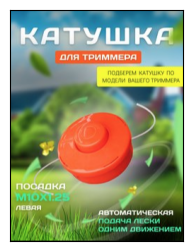

Катушка для триммера


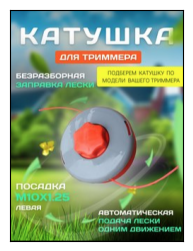

Триммер бензиновый садовый бензокоса косилка Бтр-1900П


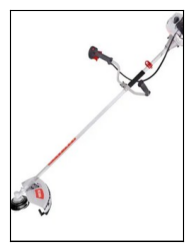

Триммер бензиновый садовый бензокоса для травы TR-2500T


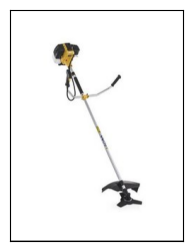

Триммер бензиновый садовый бензокоса косилка КС-1800Р


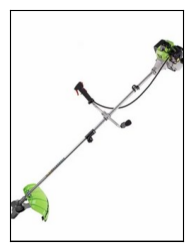

In [192]:
display_search_result(indices[:5])

Посмотрим, как выглядят колонки с соответствием поисковому запросу

In [193]:
metadata.iloc[indices, -3:]

,бензокоса,железная машинка,леска для косы
186,0,0,0
135,0,0,0
216,1,0,0
214,1,0,0
220,1,0,0
215,1,0,0
208,0,0,0
296,0,0,0
299,0,0,0
323,0,0,0


### Оценка качества результатов поиска

Для оценки качества воспользуемся изученными метриками

In [194]:
def precision_at_k(y_true: List,
                   y_score: List,
                   k: int) -> int:
    '''
    y_true (List[int]): True binary labels in {0, 1}.
    y_score (List[float]): Target scores, can either be probability estimates of the positive class.
    k (int): Number of search results.
    '''
    if len(y_true) != len(y_score):
        raise ValueError("y_true and y_score must have the same length.")
    
    if k > len(y_true):
        raise ValueError("k cannot be greater than the number of elements.")

    unique_y = np.unique(y_true)

    if len(unique_y) == 1:
        return 0
    elif len(unique_y) > 2:
        raise ValueError("Only supported for two relevance levels.")

    pos_label = unique_y[1]

    order = np.argsort(y_score)
    y_true = np.take(y_true, order[:k])
    n_relevant = np.sum(y_true == pos_label)

    return float(n_relevant) / k

def average_precision_at_k(y_true: List[int], y_score: List[float], k: int) -> float:
    """
    y_true (List[int]): True binary labels in {0, 1}.
    y_score (List[float]): Target scores, can either be probability estimates of the positive class.
    k (int): Number of search results.
    """

    if len(y_true) != len(y_score):
        raise ValueError("y_true and y_score must have the same length.")
    
    if k > len(y_true):
        raise ValueError("k cannot be greater than the number of elements.")
    
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    
    sorted_indices = np.argsort(y_score)
    
    y_true_sorted = y_true[sorted_indices]

    precision_sum = 0
    relevant_count = 0
    
    for i in range(k):
        if y_true_sorted[i] == 1:
            relevant_count += 1
            precision_sum += relevant_count / (i + 1)
    
    if relevant_count == 0:
        return 0.0
    else:
        return precision_sum / relevant_count

def reciprocal_rank(y_true: List,
                         y_score: List) -> float:
    '''
    y_true (List[int]): True binary labels in {0, 1}.
    y_score (List[float]): Target scores, probability estimates of the positive class.
    k (int): Number of search results.
    '''

    if len(y_true) != len(y_score):
        raise ValueError("y_true and y_score must have the same length.")

    pos_label = np.max(y_true)

    order = np.argsort(y_score)
    y_true = np.take(y_true, order)

    rr_score = 0
    for i, y in enumerate(y_true):
        if y == pos_label:
            rr_score = 1 / (i + 1)
            break

    return rr_score

def expected_reciprocal_rank(y_true: List, y_score: List) -> float:
    '''
    y_true (List[int]): True binary labels in {0, 1}.
    y_score (List[float]): Target scores, probability estimates of the positive class.
    '''
    if len(y_true) != len(y_score):
        raise ValueError("y_true and y_score must have the same length.")

    pos_label = np.max(y_true)

    order = np.argsort(y_score)
    y_true_sorted = np.take(y_true, order)

    reciprocal_ranks = []
    for i, y in enumerate(y_true_sorted):
        if y == pos_label:
            reciprocal_ranks.append(1.0 / (i + 1))

    if reciprocal_ranks:
        return sum(reciprocal_ranks) / len(reciprocal_ranks)
    else:
        return 0.0 

def discounted_cumulative_gain(y_true: List,
                               y_score: List,
                               k: int) -> float:
    '''
    y_true (List[int]): True binary labels in {0, 1}.
    y_score (List[float]): Target scores, probability estimates of the positive class.
    '''

    if len(y_true) != len(y_score):
        raise ValueError("y_true and y_score must have the same length.")
    
    if k > len(y_true):
        raise ValueError("k cannot be greater than the number of elements.")

    order = np.argsort(y_score)
    y_true = np.take(y_true, order[:k])

    gains = 2**y_true - 1
    discounts = np.log2(np.arange(len(y_true)) + 2)

    return np.sum(gains / discounts)

Попробуем получить оценки для тестового запроса

In [195]:
y_score = distances
y_true = metadata.iloc[indices]['бензокоса']

Precision at k

In [196]:
precision_at_k(y_true, y_score, k=20)

0.25

AR@20

In [197]:
average_precision_at_k(y_true, y_score, k=20)

0.48249999999999993

Reciprocal rank

In [198]:
reciprocal_rank(y_true, y_score)

0.3333333333333333

DCG

In [199]:
discounted_cumulative_gain(y_true, y_score, k=20)

1.9183870945341828

ERR

In [200]:
expected_reciprocal_rank(y_true, y_score)

0.20249999999999996

### Создание сводной таблицы с результами оценки 

На основе оценки результатов поиска, полученных различными методами, составим таблицу с показателями метрик качества поисковой выдачи

In [201]:

scores_table = {
    'MAP@20':[],
    'DCG@20':[],
    'MRR':[],
    'ERR': []
}

for method, instance in search_methods.items():
    method_average_precision = []
    method_dcg = []
    method_reciprocal_rank = []
    method_expected_reciprocal_rank = []
    for query in queries_dict.values():
        indices, distances = perform_search(query, instance, method.split('_')[0], k=20)
        y_score = distances
        y_true = metadata.iloc[indices][query] 
        method_average_precision.append(average_precision_at_k(y_true, y_score, k=20))
        method_dcg.append(discounted_cumulative_gain(y_true, y_score, k=20))
        method_reciprocal_rank.append(reciprocal_rank(y_true, y_score))
        method_expected_reciprocal_rank.append(expected_reciprocal_rank(y_true, y_score))
    scores_table['MAP@20'].append(np.mean(method_average_precision))
    scores_table['DCG@20'].append(np.mean(method_dcg))
    scores_table['MRR'].append(np.mean(method_reciprocal_rank))
    scores_table['ERR'].append(np.mean(method_expected_reciprocal_rank))

               


In [202]:
pd.DataFrame(scores_table, index=search_methods.keys())

,MAP@20,DCG@20,MRR,ERR
faiss_L2,0.519605,3.139235,0.461988,0.144568
faiss_IP,0.745815,3.419188,0.708333,0.336610
annoy_angular,0.533772,3.057684,0.461988,0.156234
annoy_euclidean,0.526550,3.147764,0.461988,0.145956
annoy_manhattan,0.243591,1.513743,0.195767,0.101152


Таким образом, наилучший результат продемонстрировал FAISS Inner Product. Однако объективно оценивать данные результаты невозможно, т.к. во-первых, датасет размечен автоматически, во-вторых, данные были получены из поисковой выдачи Wildberries и содержат товары из двух категорий. 